# 개념

매도, 매수를 통해 동일 비율로 유지

In [3]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data

## 사용 함수 선언

In [7]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

In [8]:
def getCloseDataPandas(ticker, start, end):
    print(ticker)
    return data.get_data_yahoo(ticker, start, end)['Close']

In [10]:
def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

In [11]:
def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]

In [17]:
def getPortfolioResult(closeDataSet, weight = None):
    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    portfolioCumulativeReturn = (weight*cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn/portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

In [18]:
def getEvaluation(cumulativeReturn):
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn)/ cumulativeReturn.cummax()*100
    mdd = dd.max()
    
    print(f"최종 수익률 : {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")
    return cagr,dd,mdd

## 리밸런싱

In [82]:
# 코스피 ETF 채권 ETF 1:1 혼합

kodex200 = getCloseData("069500", "2022") 
kodex10Bond = getCloseData("152380", "2022") 

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)
closeDataSet


,kodex200,kodex10Bond
Date,,
2022-01-03,39245,68415
2022-01-04,39221,68450
2022-01-05,38662,68030
2022-01-06,38273,67480
2022-01-07,38754,67460
...,...,...
2022-09-23,29780,60310
2022-09-26,29050,59390
2022-09-27,29105,59915


In [23]:
closeDataSet0 = pd.concat([kodex200, kodex10Bond], axis=0)
closeDataSet0.columns = ['kodex200', 'kodex10Bond']
closeDataSet0.dropna(inplace=True)
closeDataSet0

Date
2022-01-03    39245
2022-01-04    39221
2022-01-05    38662
2022-01-06    38273
2022-01-07    38754
              ...  
2022-09-23    60310
2022-09-26    59390
2022-09-27    59915
2022-09-28    59775
2022-09-29    59900
Name: Close, Length: 366, dtype: int64

매월 말 rebalancing 을 진행한다

## Dataframe index 확인

In [26]:
copyCloseDataSet = closeDataSet.copy()
print(copyCloseDataSet.index)
print(copyCloseDataSet.index.year)
print(copyCloseDataSet.index.month)
print(copyCloseDataSet.index.day)

DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14',
               ...
               '2022-09-16', '2022-09-19', '2022-09-20', '2022-09-21',
               '2022-09-22', '2022-09-23', '2022-09-26', '2022-09-27',
               '2022-09-28', '2022-09-29'],
              dtype='datetime64[ns]', name='Date', length=183, freq=None)
Int64Index([2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022,
            ...
            2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022],
           dtype='int64', name='Date', length=183)
Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
           dtype='int64', name='Date', length=183)
Int64Index([ 3,  4,  5,  6,  7, 10, 11, 12, 13, 14,
            ...
            16, 19, 20, 21, 22, 23, 26, 27, 28, 29],
           dtype='int64', name='Date', length=183)


마지막만 남기고 날린다

## 리밸런싱 기법 구현
- rebalancing data 계산


In [27]:
# 연, 월 구하기
copyCloseDataSet = closeDataSet.copy()
copyCloseDataSet['year'] = copyCloseDataSet.index.year
copyCloseDataSet['month'] = copyCloseDataSet.index.month
copyCloseDataSet

,kodex200,kodex10Bond,year,month
Date,,,,
2022-01-03,39245,68415,2022,1
2022-01-04,39221,68450,2022,1
2022-01-05,38662,68030,2022,1
2022-01-06,38273,67480,2022,1
2022-01-07,38754,67460,2022,1
...,...,...,...,...
2022-09-23,29780,60310,2022,9
2022-09-26,29050,59390,2022,9
2022-09-27,29105,59915,2022,9


In [30]:
# 기간내 매월 마지막 날짜 구하기
rebalancingDate = copyCloseDataSet.drop_duplicates(['year','month'], keep="last").index
rebalancingDate

DatetimeIndex(['2022-01-28', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30', '2022-07-29', '2022-08-31',
               '2022-09-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

## 리밸런싱 비중 계산

In [31]:
# 우선 동일비중으로 가정
defaultWeight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns) 
defaultWeight

[0.5, 0.5]

In [35]:
monthlyWeight = pd.DataFrame([defaultWeight] * len(rebalancingDate), index=rebalancingDate, columns=closeDataSet.columns)
monthlyWeight

,kodex200,kodex10Bond
Date,,
2022-01-28,0.5,0.5
2022-02-28,0.5,0.5
2022-03-31,0.5,0.5
2022-04-29,0.5,0.5
2022-05-31,0.5,0.5
2022-06-30,0.5,0.5
2022-07-29,0.5,0.5
2022-08-31,0.5,0.5
2022-09-29,0.5,0.5


In [36]:
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일
start

Timestamp('2022-01-28 00:00:00')

## (월별 리밸런싱 비중 * 누적 수익률) 구하기

In [37]:
# 첫번째 날짜는 뺴내고 두번쨰 날짜부터 진행
for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start] 
    print("start", start)
    print("end", end)
    print("weight:", weight)
    priceData = closeDataSet.loc[start:end] 
    print("priceData", priceData)
    cumReturn = getCumulativeReturn(priceData) 
    print(cumReturn)
    weightedCumReturn = weight * cumReturn 
    start = end # start 갱신
    print("---- weightedCumReturn ----")
    print(weightedCumReturn)

start 2022-01-28 00:00:00
end 2022-02-28 00:00:00
weight: kodex200       0.5
kodex10Bond    0.5
Name: 2022-01-28 00:00:00, dtype: float64
priceData             kodex200  kodex10Bond
Date                             
2022-01-28     35656        66970
2022-02-03     36000        67090
2022-02-04     36472        66785
2022-02-07     36099        66710
2022-02-08     36168        66120
2022-02-09     36670        66400
2022-02-10     36974        66410
2022-02-11     36630        66080
2022-02-14     36138        66385
2022-02-15     35917        66365
2022-02-16     36566        66425
2022-02-17     36803        66440
2022-02-18     36665        66330
2022-02-21     36689        66085
2022-02-22     36158        66400
2022-02-23     36286        66380
2022-02-24     35337        66950
2022-02-25     35735        66650
2022-02-28     36005        66685
            kodex200  kodex10Bond
Date                             
2022-01-28  1.000000     1.000000
2022-02-03  1.009648     1.001792
20

위 코드 결과 분석(~2/28)
- 주식 : 50만 3천원
- 채권 : 49만 8천원
- 결론적으로 주식을 조금 팔아서 채권을 사자!

In [46]:
# 투자 결과 연속 반영
#totalAsset = 1 # 총 자산, 초기값 1
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일
totalAsset = 1
print(totalAsset)

1


월별 투자 결과가 그 다음달에도 연속적으로 반영되어야 합니다.

갱신 전 총 자산:  1
누적수익률
            kodex200  kodex10Bond
Date                             
2022-01-28  0.500000     0.500000
2022-02-03  0.504824     0.500896
2022-02-04  0.511443     0.498619
2022-02-07  0.506212     0.498059
2022-02-08  0.507180     0.493654
2022-02-09  0.514219     0.495744
2022-02-10  0.518482     0.495819
2022-02-11  0.513658     0.493355
2022-02-14  0.506759     0.495632
2022-02-15  0.503660     0.495483
2022-02-16  0.512761     0.495931
2022-02-17  0.516084     0.496043
2022-02-18  0.514149     0.495222
2022-02-21  0.514486     0.493393
2022-02-22  0.507039     0.495744
2022-02-23  0.508834     0.495595
2022-02-24  0.495527     0.499851
2022-02-25  0.501108     0.497611
2022-02-28  0.504894     0.497872
갱신 후 총 자산:  1.0027661685606013
누적수익률
            kodex200  kodex10Bond
Date                             
2022-02-28  0.501383     0.501383
2022-03-02  0.499336     0.503939
2022-03-03  0.508847     0.502248
2022-03-04  0.500979     0.502060
2022-03-07  0.489741     

<Figure size 864x576 with 0 Axes>

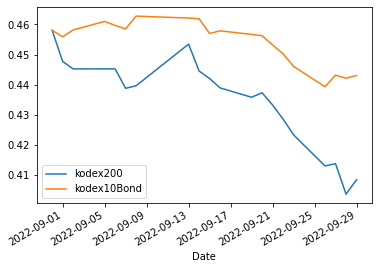

In [47]:
print("갱신 전 총 자산: ",totalAsset)
for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
    # totalAsset: 투자한 총자산
    netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
    start = end # start 갱신
    totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
    print("==========")
    print("누적수익률")
    print("==========")
    print(netCumReturn)
    print("갱신 후 총 자산: ",totalAsset)
#totalAsset
plt.figure(figsize=(12, 8))
netCumReturn.plot(label="netCumReturn")
plt.legend()

# 포트폴리오의 누적 수익률 계산

In [50]:
# 하나의 데이터 프레임으로 합치기
portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
totalAsset = 1 # 총 자산, 초기값 1
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일
for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    '''
    weightedCumReturn여기가 핵심!
    예) 100만원 ==> 6:4 면 60만 :40만
                    1.1배 : 0.8배
                    660,000:320,000 ==> 총액 98만원
                    다시 98만원을 0.6, 0.4를 곱하여 배정
    
    예시는 총액을 계산하여 분배하였는데
    
    '''
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
    netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
    '''
    현재 코드에서는 netCumReturn 과 같이 계산진행
    totalAsset값이 1이기 때문에 계산 안하는 것처럼 보임
    '''
    
    start = end # start 갱신
    totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
    portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
portfolio

,kodex200,kodex10Bond
Date,,
2022-01-28,0.500000,0.500000
2022-02-03,0.504824,0.500896
2022-02-04,0.511443,0.498619
2022-02-07,0.506212,0.498059
2022-02-08,0.507180,0.493654
...,...,...
2022-09-23,0.423248,0.446050
2022-09-26,0.412873,0.439246
2022-09-27,0.413654,0.443128


<Figure size 864x576 with 0 Axes>

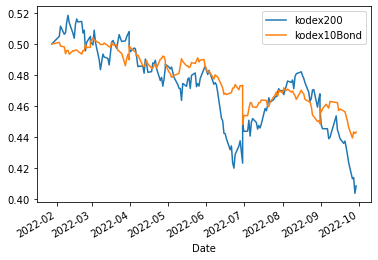

'\n처음 투자대비 돈이 줄어들고 있음\n월말에 두 선이 만나도록 진행\n'

In [52]:
#portfolio.to_excel("port1.xlsx")
#portfolio 시각화
plt.figure(figsize=(12, 8))
portfolio.plot(label="portfolio")
plt.legend()
plt.show()

'''
처음 투자대비 돈이 줄어들고 있음
월말에 두 선이 만나도록 진행
'''

In [53]:
portfolio.index.duplicated(keep='last')

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,

In [54]:
portfolio.loc[~portfolio.index.duplicated(keep='last')]

,kodex200,kodex10Bond
Date,,
2022-01-28,0.500000,0.500000
2022-02-03,0.504824,0.500896
2022-02-04,0.511443,0.498619
2022-02-07,0.506212,0.498059
2022-02-08,0.507180,0.493654
...,...,...
2022-09-23,0.423248,0.446050
2022-09-26,0.412873,0.439246
2022-09-27,0.413654,0.443128


In [55]:
portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')]
portfolio

,kodex200,kodex10Bond
Date,,
2022-01-28,0.500000,0.500000
2022-02-03,0.504824,0.500896
2022-02-04,0.511443,0.498619
2022-02-07,0.506212,0.498059
2022-02-08,0.507180,0.493654
...,...,...
2022-09-23,0.423248,0.446050
2022-09-26,0.412873,0.439246
2022-09-27,0.413654,0.443128


In [56]:
portCumReturn = portfolio.sum(axis=1)
portCumReturn

Date
2022-01-28    1.000000
2022-02-03    1.005720
2022-02-04    1.010061
2022-02-07    1.004271
2022-02-08    1.000834
                ...   
2022-09-23    0.869297
2022-09-26    0.852118
2022-09-27    0.856783
2022-09-28    0.845585
2022-09-29    0.851271
Length: 164, dtype: float64

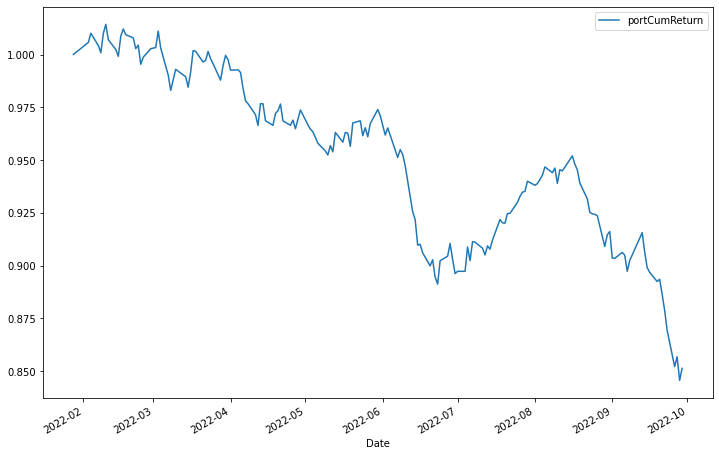

'\n100만원으로 시작했으면 85만원정도로 하락\n'

In [58]:
#portfolio 누적수익률 시각화
plt.figure(figsize=(12, 8))
portCumReturn.plot(label="portCumReturn")
plt.legend()
plt.show()

'''
100만원으로 시작했으면 85만원정도로 하락
'''

## 리밸런싱 일자 조회, 리밸런싱 포트폴리오 결과 계산 함수화

In [62]:
def getRebalancingDate(closeDataSet, period="month"):
    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
    return rebalancingDate


In [72]:
def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn


## 함수 사용으로 미국 주식과 장기채권 1:1 투자

In [73]:
# 데이터 로드
stockETF = getCloseDataPandas("SPY", "2002", "2022-6-17") # 주식 ETF
bondETF = getCloseDataPandas("IEF", "2002", "2022-6-17") # 채권 ETF
closeDataSet = pd.concat([stockETF, bondETF], axis=1)
closeDataSet.columns = ['stockETF', 'bondETF']
closeDataSet.dropna(inplace=True)
closeDataSet


SPY
IEF


,stockETF,bondETF
Date,,
2002-07-30,90.940002,81.769997
2002-07-31,91.160004,82.519997
2002-08-01,88.779999,82.860001
2002-08-02,86.790001,83.500000
2002-08-05,83.769997,83.919998
...,...,...
2022-06-13,375.000000,98.940002
2022-06-14,373.869995,98.150002
2022-06-15,379.200012,99.519997


In [74]:
rebalancingDate = getRebalancingDate(closeDataSet)
rebalancingDate

DatetimeIndex(['2002-07-31', '2002-08-30', '2002-09-30', '2002-10-31',
               '2002-11-29', '2002-12-31', '2003-01-31', '2003-02-28',
               '2003-03-31', '2003-04-30',
               ...
               '2021-09-30', '2021-10-29', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-17'],
              dtype='datetime64[ns]', name='Date', length=240, freq=None)

### 리밸런싱 포트폴리오 결과 계산

In [75]:
rebalPortfolioDayReturn, rebalPortfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet)

### 주식 채권 1:1 Buy and Hold 전략 결과 계산

사고 팔지 않고 계속 가지고 있는 것

In [76]:
portfolioDayReturn, portfolioCumulativeReturn = getPortfolioResult(closeDataSet.loc[rebalancingDate[0]:])

### 주식 100% Buy and Holde 전략 결과 계산

In [77]:
stockDayReturn = getDayReturn(stockETF.loc[rebalancingDate[0]:])
stockCumReturn = getCumulativeReturn(stockETF.loc[rebalancingDate[0]:])


### 전략별 성과 계산

In [78]:
print("리밸런싱 포트폴리오 누적 수익률")
print(rebalPortfolioCumulativeReturn.iloc[-1])
rebalCagr, rebalDD, rebalMDD = getEvaluation(rebalPortfolioCumulativeReturn)

리밸런싱 포트폴리오 누적 수익률
2.3858667389075325
최종 수익률 : 2.3858667389075325
cagr: 1.0447364764636269
mdd: 28.9889438920226


In [79]:
print("Buy & Hold 포트폴리오 누적 수익률")
print(portfolioCumulativeReturn.iloc[-1])
cagr, dd, mdd = getEvaluation(portfolioCumulativeReturn)

Buy & Hold 포트폴리오 누적 수익률
2.6138169219446326
최종 수익률 : 2.6138169219446326
cagr: 1.0495454894945424
mdd: 30.55480916229965


In [80]:
print("주식 100% 포트폴리오 누적 수익률")
print(stockCumReturn.iloc[-1])
stockCagr, stockDd, stockMdd = getEvaluation(stockCumReturn)

주식 100% 포트폴리오 누적 수익률
4.013382740830583
최종 수익률 : 4.013382740830583
cagr: 1.0724434695189662
mdd: 56.47366917817161


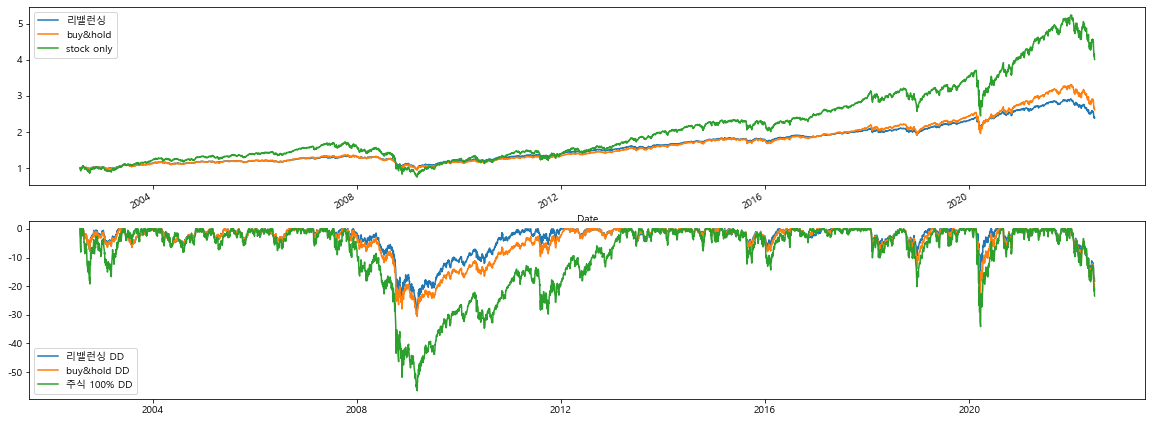

In [81]:

plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,8))
# 수익곡선
plt.subplot(2,1,1)
rebalPortfolioCumulativeReturn.plot(label="리밸런싱")
portfolioCumulativeReturn.plot(label="buy&hold")
stockCumReturn.plot(label="stock only")
plt.legend()
# dd 곡선
plt.subplot(2,1,2)
plt.plot(-rebalDD, label="리밸런싱 DD")
plt.plot(-dd, label="buy&hold DD")
plt.plot(-stockDd, label="주식 100% DD")
plt.legend()
plt.show()

- 녹색 : 주식만 가지고 있음
- 오렌지 : 주식:채권 = 1:1 사서 안팔고 가지고 있음